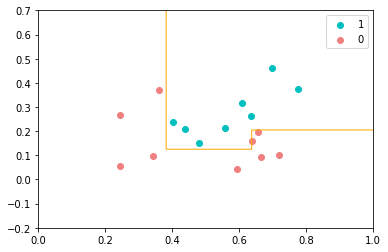

训练集的错误率:0.000%


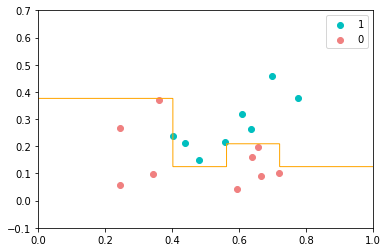

In [43]:
# -*-coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

"""
Author:
	Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Zhihu:
    https://www.zhihu.com/people/Jack--Cui/
Modify:
	2017-10-10
"""


def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
	"""
	单层决策树分类函数
	Parameters:
		dataMatrix - 数据矩阵
		dimen - 第dimen列，也就是第几个特征
		threshVal - 阈值
		threshIneq - 标志
	Returns:
		retArray - 分类结果
	"""
	retArray = np.ones((np.shape(dataMatrix)[0],1))				#初始化retArray为1
	if threshIneq == 'lt':
		retArray[dataMatrix[:,dimen] <= threshVal] = -1.0	 	#如果小于阈值,则赋值为-1
	else:
		retArray[dataMatrix[:,dimen] > threshVal] = -1.0 		#如果大于阈值,则赋值为-1
	return retArray
    

def buildStump(dataArr,classLabels,D):
	"""
	找到数据集上最佳的单层决策树
	Parameters:
		dataArr - 数据矩阵
		classLabels - 数据标签
		D - 样本权重
	Returns:
		bestStump - 最佳单层决策树信息
		minError - 最小误差
		bestClasEst - 最佳的分类结果
	"""
	dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
	m,n = np.shape(dataMatrix)
	numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
	minError = float('inf')														#最小误差初始化为正无穷大
	for i in range(n):															#遍历所有特征
		rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()		#找到特征中最小的值和最大值
		stepSize = (rangeMax - rangeMin) / numSteps								#计算步长
		for j in range(-1, int(numSteps) + 1): 									
			for inequal in ['lt', 'gt']:  										#大于和小于的情况，均遍历。lt:less than，gt:greater than
				threshVal = (rangeMin + float(j) * stepSize) 					#计算阈值
				predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
				errArr = np.mat(np.ones((m,1))) 								#初始化误差矩阵
				errArr[predictedVals == labelMat] = 0 							#分类正确的,赋值为0
				weightedError = D.T * errArr  									#计算误差
				# print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
				if weightedError < minError: 									#找到误差最小的分类方式
					minError = weightedError
					bestClasEst = predictedVals.copy()
					bestStump['dim'] = i
					bestStump['thresh'] = threshVal
					bestStump['ineq'] = inequal
	return bestStump, minError, bestClasEst

def adaBoostTrainDS(dataArr, classLabels, numIt = 10):
	"""
	使用AdaBoost算法提升弱分类器性能
	Parameters:
		dataArr - 数据矩阵
		classLabels - 数据标签
		numIt - 最大迭代次数
	Returns:
		weakClassArr - 训练好的分类器
		aggClassEst - 类别估计累计值
	"""
	weakClassArr = []
	m = np.shape(dataArr)[0]
	D = np.mat(np.ones((m, 1)) / m)    										#初始化权重
	aggClassEst = np.mat(np.zeros((m,1)))
	for i in range(numIt):
		bestStump, error, classEst = buildStump(dataArr, classLabels, D) 	#构建单层决策树
		# print("D:",D.T)
		alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16))) 		#计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
		bestStump['alpha'] = alpha  										#存储弱学习算法权重 
		weakClassArr.append(bestStump)                  					#存储单层决策树
		# print("classEst: ", classEst.T)
		expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst) 	#计算e的指数项
		D = np.multiply(D, np.exp(expon))                           		   
		D = D / D.sum()														#根据样本权重公式，更新样本权重
		#计算AdaBoost误差，当误差为0的时候，退出循环
		aggClassEst += alpha * classEst  									#计算类别估计累计值								
		# print("aggClassEst: ", aggClassEst.T)
		aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1))) 	#计算误差
		errorRate = aggErrors.sum() / m
		# print("total error: ", errorRate)
		if errorRate == 0.0: break 											#误差为0，退出循环
	return weakClassArr, aggClassEst

def adaClassify(datToClass,classifierArr):
	"""
	AdaBoost分类函数
	Parameters:
		datToClass - 待分类样例
		classifierArr - 训练好的分类器
	Returns:
		分类结果
	"""
	dataMatrix = np.mat(datToClass)
	m = np.shape(dataMatrix)[0]
	aggClassEst = np.mat(np.zeros((m,1)))
	for i in range(len(classifierArr)):										#遍历所有分类器，进行分类
		classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])			
		aggClassEst += classifierArr[i]['alpha'] * classEst
	return np.sign(aggClassEst)

def pltStumpBaggingDecisionBound(X_, y_, stumps):
    pos = y_ == 1
    neg = y_ == -1
    x_tmp = np.linspace(0, 1, 600)
    y_tmp = np.linspace(-0.1, 0.7, 600)

    X_tmp, Y_tmp = np.meshgrid(x_tmp, y_tmp)
    Z_ = adaClassify(np.c_[X_tmp.ravel(), Y_tmp.ravel()], stumps).reshape(X_tmp.shape)

    plt.contour(X_tmp, Y_tmp, Z_, [0], colors='orange', linewidths=1)

    plt.scatter(X_[pos, 0], X_[pos, 1], label='1', color='c')
    plt.scatter(X_[neg, 0], X_[neg, 1], label='0', color='lightcoral')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    data_path = r'melon.txt'

    data = pd.read_table(data_path, delimiter=' ')

    X = data.iloc[:, :2].values
    y = data.iloc[:, 2].values
    y[y == 0] = -1
    dataArr = X
    LabelArr = y
    weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, LabelArr)
    predictions = adaClassify(dataArr, weakClassArr)
    errArr = np.mat(np.ones((len(dataArr), 1)))
    print('训练集的错误率:%.3f%%' % float(errArr[predictions != np.mat(LabelArr).T].sum() / len(dataArr) * 100))
    pltStumpBaggingDecisionBound(dataArr,LabelArr,weakClassArr)

In [39]:
aggClassEst

matrix([[ 1.83601472],
        [ 2.26472025],
        [ 1.06701706],
        [ 1.06701706],
        [ 1.06701706],
        [ 1.06701706],
        [-0.47342798],
        [ 1.06701706],
        [-1.50766161],
        [-0.45903924],
        [-3.03371791],
        [-3.03371791],
        [-0.47342798],
        [-0.47342798],
        [-0.45903924],
        [-1.50766161],
        [-1.50766161]])

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import resample


def stumpClassify(X, dim, thresh_val, thresh_inequal):
    ret_array = np.ones((X.shape[0], 1))

    if thresh_inequal == 'lt':
        ret_array[X[:, dim] <= thresh_val] = -1
    else:
        ret_array[X[:, dim] > thresh_val] = -1

    return ret_array


def buildStump(X, y):
    m, n = X.shape
    best_stump = {}

    min_error = 1

    for dim in range(n):

        x_min = np.min(X[:, dim])
        x_max = np.max(X[:, dim])

        # 这里第一次尝试使用排序后的点作为分割点，效果很差，因为那样会错过一些更好的分割点；
        # 所以后来切割点改成将最大值和最小值之间分割成20等份。

        # sorted_x = np.sort(X[:, dim])
        # split_points = [(sorted_x[i] + sorted_x[i + 1]) / 2 for i in range(m - 1)]

        split_points = [(x_max - x_min) / 20 * i + x_min for i in range(20)]

        for inequal in ['lt', 'gt']:
            for thresh_val in split_points:
                ret_array = stumpClassify(X, dim, thresh_val, inequal)

                error = np.mean(ret_array != y)

                if error < min_error:
                    best_stump['dim'] = dim
                    best_stump['thresh'] = thresh_val
                    best_stump['inequal'] = inequal
                    best_stump['error'] = error
                    min_error = error

    return best_stump


def stumpBagging(X, y, nums=20):
    stumps = []
    seed = 16
    for _ in range(nums):
        X_, y_ = resample(X, y, random_state=seed)  # sklearn 中自带的实现自助采样的方法
        seed += 1
        stumps.append(buildStump(X_, y_))
    return stumps
def adaBoostTrainDS(dataArr, classLabels, numIt = 5):
	"""
	使用AdaBoost算法提升弱分类器性能
	Parameters:
		dataArr - 数据矩阵
		classLabels - 数据标签
		numIt - 最大迭代次数
	Returns:
		weakClassArr - 训练好的分类器
		aggClassEst - 类别估计累计值
	"""
	weakClassArr = []
	m = np.shape(dataArr)[0]
	D = np.mat(np.ones((m, 1)) / m)    										#初始化权重
	aggClassEst = np.mat(np.zeros((m,1)))
	for i in range(numIt):
		bestStump, error, classEst = buildStump(dataArr, classLabels, D) 	#构建单层决策树
		# print("D:",D.T)
		alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16))) 		#计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
		bestStump['alpha'] = alpha  										#存储弱学习算法权重 
		weakClassArr.append(bestStump)                  					#存储单层决策树
		# print("classEst: ", classEst.T)
		expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst) 	#计算e的指数项
		D = np.multiply(D, np.exp(expon))                           		   
		D = D / D.sum()														#根据样本权重公式，更新样本权重
		#计算AdaBoost误差，当误差为0的时候，退出循环
		aggClassEst += alpha * classEst  									#计算类别估计累计值								
		# print("aggClassEst: ", aggClassEst.T)
		aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1))) 	#计算误差
		errorRate = aggErrors.sum() / m
		# print("total error: ", errorRate)
		if errorRate == 0.0: break 											#误差为0，退出循环
	return weakClassArr, aggClassEst


def stumpPredict(X, stumps):
    ret_arrays = np.ones((X.shape[0], len(stumps)))

    for i, stump in enumerate(stumps):
        ret_arrays[:, [i]] = stumpClassify(X, stump['dim'], stump['thresh'], stump['inequal'])

    return np.sign(np.sum(ret_arrays, axis=1))


def pltStumpBaggingDecisionBound(X_, y_, stumps):
    pos = y_ == 1
    neg = y_ == -1
    x_tmp = np.linspace(0, 1, 600)
    y_tmp = np.linspace(-0.1, 0.7, 600)

    X_tmp, Y_tmp = np.meshgrid(x_tmp, y_tmp)
    Z_ = stumpPredict(np.c_[X_tmp.ravel(), Y_tmp.ravel()], stumps).reshape(X_tmp.shape)

    plt.contour(X_tmp, Y_tmp, Z_, [0], colors='orange', linewidths=1)

    plt.scatter(X_[pos, 0], X_[pos, 1], label='1', color='c')
    plt.scatter(X_[neg, 0], X_[neg, 1], label='0', color='lightcoral')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    data_path = r'..\data\watermelon3_0a_Ch.txt'

    data = pd.read_table(data_path, delimiter=' ')

    X = data.iloc[:, :2].values
    y = data.iloc[:, 2].values

    y[y == 0] = -1

    stumps = stumpBagging(X, y, 21)

    print(np.mean(stumpPredict(X, stumps) == y))
    pltStumpBaggingDecisionBound(X, y, stumps)